In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import time
import warnings
from ipynb.fs.defs.functions import new_route
from ipynb.fs.defs.functions import get_row
from ipynb.fs.defs.functions import get_column
from ipynb.fs.defs.functions import getName
from ipynb.fs.defs.functions import timeDistance
from ipynb.fs.defs.functions import best_index
from ipynb.fs.defs.functions import find_best_position
from ipynb.fs.defs.functions import cities_list
from ipynb.fs.defs.functions import random_schedule_day
warnings.filterwarnings('ignore')

table=pd.read_csv("../Dati/orari/route.csv", delimiter=";")
time_table=pd.read_csv("../Dati/orari/route_time.csv", delimiter=";")
dft = pd.read_csv("../Dati/distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../Dati/distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)

In [2]:
#(inizio e fine compresi)
#Ritorna una lista contenente le chiavi di due città e il tempo di percorrenza tra le due
#nel formato (times, "key1 - key2")
#"key1 - key2" è la chiave
#La lista partirà dalla posizione "inizio" della schedulazione e finità con "fine"
def route(schedule, inizio, fine, dft):
    times = []
    keys = []
    row = dft[get_row(dft, schedule[inizio]).values]
    key1 = ''
    key2 = ''
    impossibile = []
    
    for i in range(inizio+1,fine+1):
        key1 = row.index[0]
        try:
            paese=schedule[i]
            if 'Martignana' in paese:
                paese = 'Martignana di Po'
        except:
            continue
        #Distanze in tempo dal paese corrente di ognuno dei furgoni alla destinazione
        value=row.loc[:,get_column(dft, paese).values].values[0][0]
        times.append(round(value))
        row = dft[get_row(dft, paese).values]
        key2 = row.index[0]
        keys.append(key1 + ' $ ' + key2)
    
    steps_times1 = pd.Series(times , keys)
    return steps_times1

In [3]:
#Datogli una schedulazione calcola il tempo di percorrenza
def schedule_time(schedule, dft):
    times = []
    row = dft[get_row(dft, 'Cremona, sesto 39').values]

    for i in range(1, len(schedule)):
        paese=schedule[i]
        if 'Martignana' in paese:
            paese = 'Martignana di Po'

        value=row.loc[:,get_column(dft, paese).values].values[0][0]
        times.append(round(value))
        
        row = dft[get_row(dft, paese).values]
    return sum(times)

In [4]:
#mantiene il nodo inizial e il successivo a y invariati, mentre fa il reverse della lista tra i due
#A-b-c-d-E -> A-d-c-b-E
def cross(schedule, x, y):
    i = [schedule[x]]
    j1 = [schedule[y+1]]
    j1_i1 = list(schedule[x+1: y+1].sort_index(ascending = False).values) 
    return i + j1_i1 + j1

In [5]:
#Data una schedulazione e due nodi di cui fare l'incrocio dei nodi
#effettua la tabulazione del nuovo percorso, dopodichè restituisce il migliore
#tra il nuovo e il vecchio
def two_opt(schedule , i, j, dft):
    #computo la prima parte che rimane uguale
    first_part = route(schedule, 0, i, dft)

    #stesso per l'ultima
    final_part = route(schedule, j+1, len(schedule), dft)
    #print(final_part)
    crossed = cross(schedule, i, j)
    central_part = route(crossed, 0,len(crossed), dft)
    
    new_schedule = first_part.append(central_part).append(final_part)
    if(schedule_time(schedule, dft)> sum(new_schedule.values)):
        return new_schedule
    else:
        return route(schedule, 0, len(schedule), dft)

In [6]:
idx = dft.index[0:35]
dft = pd.read_csv("../Dati/distanze/synthetic_costs.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dft.columns = idx[:]
dft.index = idx[:]
tries = range(5, 36, 5)
benchmark_time_s = pd.read_csv("../Dati/altro/synt_benchmark.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
benchmark_time_s = pd.concat([benchmark, pd.Series(index=["2opt"], dtype=float)])[[str(x) for x in tries]]
benchmark_counter_s = pd.read_csv("../Dati/altro/synt_benchmark_counter.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
benchmark_counter_s = pd.concat([benchmark, pd.Series(index=["2opt"], dtype=float)])[[str(x) for x in tries]]
#tries = [20]
for n in tries:
    print(n)
    tot = 0
    counter=0
    schedule = random_schedule_day(dft, n+2)
    best_schedule = pd.Series(schedule)
    best_time = schedule_time(schedule, dft)
    local_best_time = best_time
    
    while(True):
        startime = time.time()
        for i in range(1, len(schedule)-2):
            for j in range(i+1, len(schedule)-1):
                s = two_opt(pd.Series(schedule), i, j, dft)
                t = sum(s.values)
                if schedule_time(best_schedule, dft)> t:
                    best_time = t.copy()
                    best_schedule = cities_list(s) 
        counter += 1
        tot += (time.time() - startime)
        if(local_best_time>best_time):
            schedule = best_schedule[:]
            local_best_time = best_time
        else:
            break
        
    benchmark_counter_s[str(n)]["2opt"] = counter, 3
    benchmark_time_s[str(n)]["2opt"] = round(tot/counter, 3)
    print(counter)
    

FileNotFoundError: [Errno 2] File b'../Dati/altro/synt_benchmark.csv' does not exist: b'../Dati/altro/synt_benchmark.csv'

In [8]:
benchmark_count_s.to_csv("../Dati/altro/synt_benchmark_counter.csv", sep=";", encoding = "ISO-8859-1")
benchmark_time_s.to_csv("../Dati/altro/synt_benchmark.csv", sep=";", encoding = "ISO-8859-1")

168.13149976730347

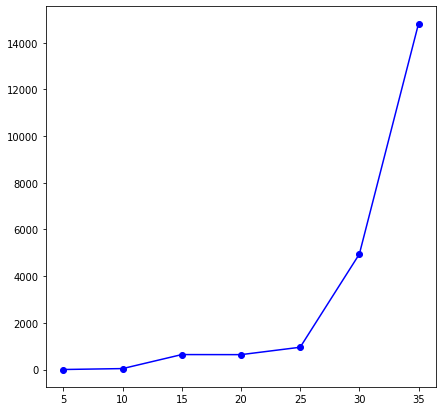

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
plt.plot(benchmark.loc["2opt"], "bo-")
plt.show()
benchmark.to_csv("../Dati/altro/benchmark.csv", sep=";", encoding = "ISO-8859-1")

In [6]:
pd.read_csv("../Dati/turni_f/fine_optimized_start/foss_ls1.csv", delimiter=";", encoding = "ISO-8859-1")

,lunedi,martedi,mercoledi,giovedi,venerdi
0,"Cremona, Sesto 39","Cremona, Sesto 39","Cremona, Sesto 39","Cremona, Sesto 39","Cremona, Sesto 39"
1,"Izano, Gerardo da Izano, 4/C","Grumello Cremonese ed Uniti, Roma, 2","Sesto ed Uniti, Roma, 4","Annicco, Giuseppe Garibaldi, 6","Cremona, Sesto 39"
2,"Crema, Civerchi, 9","Pizzighettone, Giuseppe Garibaldi, 18","Pizzighettone, Giuseppe Garibaldi, 18","Paderno Ponchielli, Municipio, 3","Cremona, Ugolani Dati, 4"
3,"Capergnanica, XI febbraio, 7","Ostiano, Mazzini, 1","Casalpusterlengo, Pusterla 7","Soresina, Giacomo Matteotti, 6","Gadesco-Pieve Delmona, Giovanni Lonati 9"
4,"Bagnolo Cremasco, Roma, 3",NaN,"Montodine, XXV Aprile, 10","San Bassano, Mons. Frosi","Grontardo, Roma, 16"
5,"Vaiano Cremasco, Gloriosi Caduti, 3",NaN,"Ripalta Cremasca, Roma, 5","Castelleone, Roma, 67","Isola Dovarese, Giacomo Matteotti, 1"
6,"Dovera, Oldrini 2",NaN,"Crema, Civerchi, 9","Fiesco, Giuseppe Parini, 10","Piadena, Platina, 40"
7,"Spino d'Adda, Circonvallazione, 13",NaN,"Pianengo, Nenni","Romanengo, Guaiarini, 14","Solarolo Rainerio, Giuseppina, 81"
8,"Agnadello, Marconi, 6",NaN,"Ricengo, Guglielmo Marconi","Soncino, Dante Alighieri, 23","Cingia de' Botti, Giuseppina, 79"
9,"Trescore Cremasco, Vittorio Veneto, 1",NaN,"Offanengo, Clavelli Martini, 5","Camisano, Trieste, 57","Casalmaggiore, Guglielmo Marconi, 8"


In [9]:
#TIME 2-OPT
week= ['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi']
results = pd.read_csv("../Dati/altro/computational_times_FOSS.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
results = pd.concat([results, pd.Series(index=["2opt"])])
fur1 = pd.read_csv("../Dati/turni_f/fine_optimized_start/foss_ls1.csv", delimiter=";", encoding = "ISO-8859-1")
df = pd.DataFrame({})
for day in week:
    print(day)
    #Otteniamo la schedulazione unendo Cremona-tabella del giorno-Ostiano
    #schedule = pd.Series('Cremona, sesto 39')
    schedule = fur1[day].dropna()
    #schedule = schedule.append(pd.Series('Ostiano, Mazzini, 1' , [len(schedule)]))
    #print(schedule)
    #Otteniamo la schedulazione filtrando i nan e salviamo anche il suo tempo di percorrenza
    best_schedule = pd.Series(schedule.dropna())
    best_time = schedule_time(schedule, dft)
    local_best_time = best_time
    #Per ogni i e j effettua il 2-opt e salva se il risultato migliora con lo scambio
    #Alla fine, avendo provato a scambiare tutte le coppie e avendole confrontate otteremo la miglior schedulazione
    #per ogni giro di 2-opt parte dalla schedulazione greedy
    count = 0
    tot = 0
    while(True):
        startime = time.time()
        for i in range(1, len(schedule)-2):
            for j in range(i+1, len(schedule)-1):
                s = two_opt(pd.Series(schedule), i, j, dft)
                t = sum(s.values)
                if schedule_time(best_schedule, dft)> t:
                    best_time = t.copy()
                    best_schedule = cities_list(s) 
        tot += (time.time() - startime)
        count += 1
        if(local_best_time>best_time):
            schedule = best_schedule[:]
            local_best_time = best_time
        else:
            break
    df = pd.concat([df, pd.DataFrame(pd.Series(best_schedule).rename(day))], axis=1)
    results[day]["2opt"]=(round((tot/count),3), len(fur1[day].dropna())-2, count)
#df.to_csv('../Dati/turni_f/fine_optimized_start/foss_2opt1.csv', index=False, sep=";", encoding = "ISO-8859-1")

lunedi
martedi
mercoledi
giovedi
venerdi


In [10]:
results = results[fur1.columns]
results.to_csv("../Dati/altro/computational_times_FOSS.csv", sep=";", encoding = "ISO-8859-1")
results

,lunedi,martedi,mercoledi,giovedi,venerdi
greedy,"(0.069, 10)","(0.016, 3)","(0.312, 16)","(0.249, 14)","(0.165, 16)"
LS,"(0.0, 10, 1)","(0.0, 2, 1)","(0.0, 17, 1)","(1.496, 16, 2)","(1.546, 16, 2)"
2opt,"(4.692, 10, 2)","(0.03, 2, 1)","(23.985, 17, 6)","(25.002, 16, 1)","(20.613, 16, 8)"


In [7]:
week= ['martedi', 'mercoledi', 'giovedi']
fur2 = pd.read_csv("../Dati/turni_f/o", delimiter=";", encoding = "ISO-8859-1")
df = pd.DataFrame({})
for day in week:
    print(day)
    #schedule = pd.Series('Cremona, sesto 39')
    schedule = fur2[day].dropna()
    #schedule = schedule.append(pd.Series('San Giovanni in Croce, Feudatari, 25 A' , [len(schedule)]))
    #print(schedule)
    best_schedule = pd.Series(schedule.dropna())
    best_time = schedule_time(schedule, dft)
    local_best_time = best_time
    while(True):
        for i in range(1, len(schedule)-2):
            for j in range(i+1, len(schedule)-1):
                s = two_opt(pd.Series(schedule), i, j, dft)
                t = sum(s.values)
                if schedule_time(best_schedule, dft)> t:
                    best_time = t.copy()
                    best_schedule = cities_list(s) 
        if(local_best_time>best_time):
            schedule = best_schedule[:]
            local_best_time = best_time
        else:
            break 
    df = pd.concat([df, pd.DataFrame(pd.Series(best_schedule).rename(day))], axis=1)        
#df.to_csv('../Dati/turni_f/fine_optimized_start/foss_2opt2.csv', index=False, sep=";", encoding = "ISO-8859-1")

martedi
mercoledi
giovedi


In [11]:
#KM 2-OPT
week= ['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi']
df = pd.DataFrame({})
for day in week:
    print(day)
    #Otteniamo la schedulazione unendo Cremona-tabella del giorno-Ostiano
    #schedule = pd.Series('Cremona, sesto 39')
    schedule = fur1d[day].dropna()
    #schedule = schedule.append(pd.Series('Ostiano' , [len(schedule)]))
    #print(schedule)
    #Otteniamo la schedulazione filtrando i nan e salviamo anche il suo tempo di percorrenza
    best_schedule = pd.Series(schedule.dropna())
    best_time = schedule_time(schedule, dfd)
    local_best_time = best_time
    #Per ogni i e j effettua il 2-opt e salva se il risultato migliora con lo scambio
    #Alla fine, avendo provato a scambiare tutte el coppie e avendole confrontate otteremo la miglior schedulazione
    #per ogni giro di 2-opt parte dalla schedulazione greedy
    while(True):
        for i in range(1, len(schedule)-2):
            for j in range(i+1, len(schedule)-1):
                s = two_opt(pd.Series(schedule), i, j, dfd)
                t = sum(s.values)
                if schedule_time(best_schedule, dfd)> t:
                    best_time = t.copy()
                    best_schedule = cities_list(s) 
        if(local_best_time>best_time):
            schedule = best_schedule[:]
            local_best_time = best_time
        else:
            break
    df = pd.concat([df, pd.DataFrame(pd.Series(best_schedule).rename(day))], axis=1)       
df.to_csv('../Dati/turni_f/optimized_start/oss_2opt_km_f1.csv', index=False, sep=";", encoding = "ISO-8859-1")

lunedi
martedi
mercoledi
giovedi
venerdi


In [12]:
week= ['martedi', 'mercoledi', 'giovedi']
df = pd.DataFrame({})
for day in week:
    print(day)
    #schedule = pd.Series('Cremona, sesto 39')
    schedule = fur2d[day].dropna()
    #schedule = schedule.append(pd.Series('San Giovanni in Croce, Feudatari, 25 A' , [len(schedule)]))
    #print(schedule)
    best_schedule = pd.Series(schedule.dropna())
    best_time = schedule_time(schedule, dfd)
    local_best_time = best_time
    while(True):
        for i in range(1, len(schedule)-2):
            for j in range(i+1, len(schedule)-1):
                s = two_opt(pd.Series(schedule), i, j, dfd)
                t = sum(s.values)
                if schedule_time(best_schedule, dfd)> t:
                    best_time = t.copy()
                    best_schedule = cities_list(s) 
        if(local_best_time>best_time):
            schedule = best_schedule[:]
            local_best_time = best_time
        else:
            break 
    df = pd.concat([df, pd.DataFrame(pd.Series(best_schedule).rename(day))], axis=1)        
df.to_csv('../Dati/turni_f/optimized_start/oss_2opt_km_f2.csv', index=False, sep=";", encoding = "ISO-8859-1")

martedi
mercoledi
giovedi
